In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte
from skimage.restoration import denoise_bilateral
from skimage import filters
import easyocr

reader = easyocr.Reader(['vi'])
class TemplateCardDetector:
    def __init__(self, template_path):
        """
        Initialize detector with a template card image
        template_path: path to the reference ID card image
        """
        self.template = cv2.imread(template_path)
        if self.template is None:
            raise ValueError("Could not load template image")
            
        # Convert template to grayscale
        self.template_gray = cv2.cvtColor(self.template, cv2.COLOR_BGR2GRAY)
        
        # Initialize feature detector
        self.sift = cv2.SIFT_create()
        
        # Compute template keypoints and descriptors
        self.template_keypoints, self.template_descriptors = self.sift.detectAndCompute(
            self.template_gray, None
        )
        
        # Card specifications
        self.CARD_LENGTH_MM = 85.6
        self.CARD_WIDTH_MM = 53.98
        self.CARD_ASPECT_RATIO = self.CARD_LENGTH_MM / self.CARD_WIDTH_MM
        
        # Initialize feature matcher
        self.matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    def detect_card_multi_method(self, image):
        """
        Detect card using multiple methods and combine results
        Returns the most confident detection
        """
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 1. Feature Matching
        feature_points = self.feature_matching(gray)
        
        # 2. Template Matching
        template_points = self.template_matching(gray)
        
        # 3. Edge Detection
        edge_points = self.edge_based_detection(gray)
        
        # Combine and validate results
        all_detections = []
        
        # Ensure consistent array shape for all detections
        if feature_points is not None:
            all_detections.append(np.array(feature_points, dtype=np.int32))
        if template_points is not None:
            all_detections.append(np.array(template_points, dtype=np.int32))
        if edge_points is not None:
            all_detections.append(np.array(edge_points, dtype=np.int32))
        
        if not all_detections:
            return None
            
        # Select best detection based on confidence metrics
        best_detection = self.select_best_detection(all_detections, gray)
        
        return best_detection

    def feature_matching(self, gray_image):
        """
        Detect card using SIFT feature matching
        """
        # Detect keypoints and compute descriptors
        keypoints, descriptors = self.sift.detectAndCompute(gray_image, None)
        
        if descriptors is None or len(keypoints) < 4:
            return None
            
        # Match features
        matches = self.matcher.match(self.template_descriptors, descriptors)
        
        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)
        
        # Filter good matches
        good_matches = matches[:min(30, len(matches))]
        
        if len(good_matches) < 4:
            return None
            
        # Extract matched keypoints
        template_pts = np.float32([self.template_keypoints[m.queryIdx].pt 
                                 for m in good_matches]).reshape(-1, 1, 2)
        image_pts = np.float32([keypoints[m.trainIdx].pt 
                              for m in good_matches]).reshape(-1, 1, 2)
        
        # Find homography
        H, mask = cv2.findHomography(template_pts, image_pts, cv2.RANSAC, 5.0)
        
        if H is None:
            return None
            
        # Get template corners
        h, w = self.template_gray.shape
        template_corners = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]]).reshape(-1, 1, 2)
        
        # Transform corners
        transformed_corners = cv2.perspectiveTransform(template_corners, H)
        return transformed_corners.reshape(-1, 2)

    def template_matching(self, gray_image):
        """
        Detect card using template matching at multiple scales
        """
        best_score = float('-inf')
        best_corners = None
        
        # Try different scales
        for scale in np.linspace(0.5, 2.0, 20):
            # Resize template
            resized_template = cv2.resize(self.template_gray, None, 
                                        fx=scale, fy=scale)
            
            if resized_template.shape[0] > gray_image.shape[0] or \
               resized_template.shape[1] > gray_image.shape[1]:
                continue
                
            # Template matching
            result = cv2.matchTemplate(gray_image, resized_template, 
                                     cv2.TM_CCOEFF_NORMED)
            
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            
            if max_val > best_score:
                best_score = max_val
                h, w = resized_template.shape
                corners = np.array([
                    [max_loc[0], max_loc[1]],
                    [max_loc[0] + w, max_loc[1]],
                    [max_loc[0] + w, max_loc[1] + h],
                    [max_loc[0], max_loc[1] + h]
                ], dtype=np.int32)
                best_corners = corners
        
        return best_corners if best_score > 0.5 else None

    def edge_based_detection(self, gray_image):
        """
        Detect card using edge detection and contour analysis
        """
        # Edge detection
        edges = cv2.Canny(gray_image, 50, 150)
        
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        
        best_contour = None
        best_score = float('-inf')
        
        for contour in contours:
            # Approximate contour
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            
            if len(approx) == 4:
                # Calculate aspect ratio
                rect = cv2.minAreaRect(approx)
                width = min(rect[1])
                height = max(rect[1])
                if width == 0:
                    continue
                    
                aspect_ratio = height / width
                aspect_score = 1 - abs(aspect_ratio - self.CARD_ASPECT_RATIO)
                
                # Calculate area score
                area = cv2.contourArea(approx)
                area_score = area / (gray_image.shape[0] * gray_image.shape[1])
                
                # Combined score
                score = aspect_score * area_score
                
                if score > best_score:
                    best_score = score
                    best_contour = approx.reshape(-1, 2)
        
        return best_contour if best_contour is not None else None

    def select_best_detection(self, detections, gray_image):
        """
        Select the best detection based on multiple confidence metrics
        """
        best_score = float('-inf')
        best_detection = None
        
        for detection in detections:
            # Ensure detection is in the correct shape
            detection_reshaped = detection.reshape(-1, 2)
            
            # Calculate confidence metrics
            # 1. Aspect ratio score
            rect = cv2.minAreaRect(detection_reshaped)
            width = min(rect[1])
            height = max(rect[1])
            if width == 0:
                continue
            aspect_ratio = height / width
            aspect_score = 1 - abs(aspect_ratio - self.CARD_ASPECT_RATIO)
            
            # 2. Area score
            area = cv2.contourArea(detection_reshaped)
            area_score = min(area / (gray_image.shape[0] * gray_image.shape[1]), 1.0)
            
            # 3. Rectangle similarity score
            similarity_score = self.calculate_rectangle_similarity(detection_reshaped)
            
            # Combined score
            score = (aspect_score * 0.4 + area_score * 0.3 + similarity_score * 0.3)
            
            if score > best_score:
                best_score = score
                best_detection = detection_reshaped
        
        return best_detection

    def calculate_rectangle_similarity(self, points):
        """
        Calculate how similar the detection is to a perfect rectangle
        """
        # Ensure points are in the correct shape
        points = points.reshape(-1, 2)
        
        # Sort points in clockwise order
        center = np.mean(points, axis=0)
        angles = np.arctan2(points[:, 1] - center[1],
                           points[:, 0] - center[0])
        sorted_idx = np.argsort(angles)
        sorted_points = points[sorted_idx]
        
        # Calculate angles between edges
        angles = []
        for i in range(4):
            p1 = sorted_points[i]
            p2 = sorted_points[(i+1)%4]
            p3 = sorted_points[(i+2)%4]
            
            v1 = p2 - p1
            v2 = p3 - p2
            
            angle = abs(np.degrees(
                np.arctan2(np.cross(v1, v2), np.dot(v1, v2))
            ))
            angles.append(angle)
        
        # Perfect rectangle has 90-degree angles
        angle_score = 1 - np.mean([abs(angle - 90) / 90 for angle in angles])
        
        return angle_score

    def draw_detection(self, image, detection):
        """
        Draw the detected card region on the image
        """
        output = image.copy()
        
        if detection is not None:
            # Ensure detection is in the correct format for drawing
            detection_reshaped = detection.reshape(-1, 1, 2)
            
            # Draw contour
            cv2.drawContours(output, [detection_reshaped], -1, (0, 255, 0), 2)
            
            # Draw corners
            for point in detection:
                cv2.circle(output, tuple(map(int, point)), 5, (0, 0, 255), -1)
        
        return output

    def crop_and_resize_card(self, image, detection):
        """
        Crop the detected card region and resize it to the original card size.
        Returns the cropped and resized card image.
        """
        if detection is None:
            raise ValueError("No card detected to crop and resize.")
        
        # Define the original card size in pixels (we can assume 300 DPI for high quality)
        DPI = 300
        card_length_px = int(self.CARD_WIDTH_MM / 25.4 * DPI)  # convert mm to inches and multiply by DPI
        card_width_px = int(self.CARD_LENGTH_MM / 25.4 * DPI)
        print(card_width_px,card_length_px)

        # Define the points for the output image (destination points)
        dst_points = np.array([
            [0, 0],
            [card_width_px - 1, 0],
            [card_width_px - 1, card_length_px - 1],
            [0, card_length_px - 1]
        ], dtype="float32")
        
        # Convert detection points to float32 for perspective transform
        src_points = np.array(detection, dtype="float32")

        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(src_points, dst_points)

        # Apply the perspective transformation to get the cropped and resized card image
        cropped_resized_card = cv2.warpPerspective(image, M, (card_width_px, card_length_px))
        
        return cropped_resized_card

    # Draw the detection method remains the same, but we modify main for cropping and resizing



        


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


1011 637
Box: [[291, 16], [803, 16], [803, 65], [291, 65]]. Detected text: CỘNG HÒA XÃ HỘl CHỦ NGHĨA VIỆT NAM (Confidence: 0.64)
Box: [[404, 54], [490, 54], [490, 88], [404, 88]]. Detected text: Độc lậP (Confidence: 0.58)
Box: [[492, 52], [564, 52], [564, 86], [492, 86]]. Detected text: Iựdo (Confidence: 0.34)
Box: [[565, 51], [687, 51], [687, 89], [565, 89]]. Detected text: Hanh phúc (Confidence: 0.70)
Box: [[366, 82], [722, 82], [722, 114], [366, 114]]. Detected text: SOCIALIST REPUBLIC OF VIET NAM (Confidence: 0.79)
Box: [[368, 100], [511, 100], [511, 138], [368, 138]]. Detected text: Independence (Confidence: 1.00)
Box: [[511, 100], [719, 100], [719, 140], [511, 140]]. Detected text: Freedom _ Happiness (Confidence: 0.81)
Box: [[289, 133], [805, 133], [805, 203], [289, 203]]. Detected text: CĂN CƯỚC CÔNG DÂN (Confidence: 0.89)
Box: [[291, 205], [526, 205], [526, 248], [291, 248]]. Detected text: Citizen Identity Card (Confidence: 0.98)
Box: [[293, 263], [397, 263], [397, 303], [293

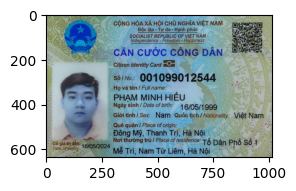

In [2]:
# Example usage
detector = TemplateCardDetector('CCCD_sample.jpg')

# Read test image
image = cv2.imread('Itest2.jfif')
if image is None:
    print("Error: Could not read test image")

# Detect card
laplacian_filter = np.array([[0, -1, 0],
                            [-1, 5, -1],
                            [0, -1, 0]], dtype='float32')

# Áp dụng bộ lọc làm sắc nét dựa trên ảnh gốc
card_sharpened = cv2.filter2D(image, -1, laplacian_filter)
detection = detector.detect_card_multi_method(card_sharpened)

if detection is not None:
    # Draw result
    result = detector.draw_detection(image, detection)
    plt.figure()
    # Display detection result
    # plt.subplot(1, 2, 1)
    # plt.imshow(result)



    # Crop and resize the detected card
    cropped_resized_card = detector.crop_and_resize_card(image, detection)
    result = reader.readtext(cropped_resized_card,add_margin = 0.3)
    for (bbox, text, prob) in result:
    # Display bounding box and text
        print(f'Box: {bbox}. Detected text: {text} (Confidence: {prob:.2f})')
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        # if bbox[0][0]>298 and bbox[0][1]>268  and bbox[1][0]<800 and  bbox[1][1]<800:



    # # Draw the bounding box on the image
    #     cv2.rectangle(cropped_resized_card, top_left, bottom_right, (0, 255, 0), 2)
    #     cv2.putText(cropped_resized_card, text, (top_left[0], top_left[1] - 10), 
    #         cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # photo_x1, photo_y1 =  64, 248 # Adjusted offsets within the bounding box
    # photo_x2, photo_y2 = 319, 637  # Adjusted offsets within the bounding box

    # img1 = cropped_resized_card[photo_y1:photo_y2, photo_x1:photo_x2]
    # img2 = cv2.imread('.\\462550227_7948962425204656_3613250314361774410_n.jpg')
    # # Initialize the face detector
    # face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # # Detect faces in each image
    # bbox1 = face_cascade.detectMultiScale(img1, scaleFactor=1.1, minNeighbors=5)
    # bbox2 = face_cascade.detectMultiScale(img2, scaleFactor=1.1, minNeighbors=5)

    # if len(bbox1) > 0 and len(bbox2) > 0:
    #     # Crop the detected face regions
    #     x, y, w, h = bbox1[0]
    #     face1 = img1[y:y+h, x:x+w]
    #     x, y, w, h = bbox2[0]
    #     face2 = img2[y:y+h, x:x+w]

# # Resize the faces to a standard size (e.g., 224x224)
#     face1_resized = cv2.resize(face1, (250, 250))
#     face2_resized = cv2.resize(face2, (250, 250))

# # Convert to grayscale (optional, if you want a color-independent comparison)
#     face1_gray = cv2.cvtColor(face1_resized, cv2.COLOR_BGR2GRAY)
#     face2_gray = cv2.cvtColor(face2_resized, cv2.COLOR_BGR2GRAY)

    # # Áp dụng bộ lọc làm sắc nét dựa trên ảnh gốc
    # I_sharpened = cv2.filter2D(face1_gray, -1, laplacian_filter)
    # # Compute Structural Similarity Index (SSIM)
    # ssim_val, ssim_map = ssim(I_sharpened, face2_gray, full=True)
    # print(f'The SSIM value for the two faces is {ssim_val:.4f}')
    
    # # Display the cropped and resized card
    # plt.subplot(1, 2, 1)
    # plt.imshow(I_sharpened)

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_resized_card)
    plt.show()
else:
    print("No card detected")   

In [3]:
class CardInfo:
    def __init__(self):
        self.citizen_card_no = None
        self.full_name = None
        self.dob  = None
        self.gender = None
        self.nationality = None
        self.place_of_origin = None
        self.place_of_residence  = None
        self.date_of_expiry = None
        
    def retrieve_card_info(self, x1, y1, x2, y2,text):
        if x1>400 and y1>230 and  y2<326:
            self.citizen_card_no = text.strip()
        if x1>260 and y1>324 and  y2<409:
            self.full_name = text.strip()
        if  x1>580 and y1>380 and  y2<460:
            self.dob = text.strip()
        if x1>470 and y1>420 and x2<580 and  y2<490:
            self.gender = text.strip()
        if x1>810 and y1>420 and  y2<490:
            self.nationality = text.strip()
        if x1>570 and y1>470 and  y2<520:
            self.place_of_origin = text.strip()
        if x1>260 and y1>490 and  y2<570:
            self.place_of_origin = ((self.place_of_origin or '') + ' ' + text.strip()).strip()
        if x1>670 and y1>520 and  y2<610:
            self.place_of_residence = text.strip()
        if x1 > 260 and y1 > 560:
            self.place_of_residence = ((self.place_of_residence or '') + ' ' + text.strip()).strip()
        if x1>130 and y1>550 and x2<300 and  y2<630:
            self.date_of_expiry = text.strip()
            


In [10]:
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# Load and preprocess the image
image = cropped_resized_card


image2 = cv2.addWeighted(image, 2, np.zeros(image.shape, image.dtype), 0, 0) 
# blur = cv2.GaussianBlur(image2,(5,5),0)

# # Get the original dimensions
# (h, w) = image.shape[:2]

# # Desired width
# new_width = 300

# # Calculate the aspect ratio
# aspect_ratio = h / w
# new_height = int(new_width * aspect_ratio)

# # Resize the image
# resized_image = cv2.resize(image, (new_width, new_height))


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Apply Sobel operator in x-direction
# sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)

# # Apply Sobel operator in y-direction
# sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# # Combine x and y gradients for edge magnitude
# sobelxy = cv2.magnitude(sobelx, sobely)
_, binary_image = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)


# binary_image = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY_INV,11,20)
# Define a kernel
kernel = np.ones((2,2), np.uint8)

# Apply erosion
erosion = cv2.erode(binary_image, kernel, iterations = 1)

# Apply dilation
dilation = cv2.dilate(erosion, kernel, iterations = 1)

# Apply erosion
erosion = cv2.erode(binary_image, kernel, iterations = 1)

# Apply dilation
dilation = cv2.dilate(erosion, kernel, iterations = 1)

# # Apply erosion
erosion = cv2.erode(dilation, kernel, iterations = 1)

# # Apply dilation
dilation = cv2.dilate(erosion, kernel, iterations = 2)

# # Apply erosion
# erosion = cv2.erode(binary_image, kernel, iterations = 1)

# # Apply dilation
# dilation = cv2.dilate(erosion, kernel, iterations = 1)
# # Apply erosion
# erosion = cv2.erode(binary_image, kernel, iterations = 1)

# Apply dilation
# dilation = cv2.dilate(erosion, kernel, iterations = 1)
# denoised = cv2.bilateralFilter(binary_image, d=11, sigmaColor=75, sigmaSpace=75)

# Apply dilation for text enhancement
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
# dilated = cv2.dilate(denoised, kernel, iterations=1)


# # OCR Configuration
# custom_config = r'--oem 3 --psm 4'

# # Extract text
# text = pytesseract.image_to_string(binary_image, config=custom_config, lang='vie')

# print("Extracted Text:")
# print(text)

In [6]:
import cv2

cv2.imshow('Image with Inpainted Background', binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [8]:
cv2.imshow('Image with Inpainted Background', binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [4]:


gray = cv2.cvtColor(cropped_resized_card, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)

kernel = np.ones((2,2), np.uint8)


result = reader.readtext(binary_image, add_margin = 0.2,width_ths =0.4, ycenter_ths =0.4, height_ths =0.4,rotation_info = [10,350])
cardHieu = CardInfo()
for (bbox, text, prob) in result:
# Display bounding box and text
    print(f'Box: {bbox}. Detected text: {text} (Confidence: {prob:.2f})')
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    cardHieu.retrieve_card_info(top_left[0],top_left[1],bottom_right[0],bottom_right[1],text)
    

import inspect

for i in inspect.getmembers(cardHieu):
     
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):
         
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]): 
            print(i)

Box: [[294, 19], [800, 19], [800, 62], [294, 62]]. Detected text: CỘNG HÒA XÃ HỘl CHỦ NGHĨA VIỆT NAM (Confidence: 0.49)
Box: [[406, 54], [490, 54], [490, 84], [406, 84]]. Detected text: Độc lậP (Confidence: 0.56)
Box: [[496, 54], [564, 54], [564, 82], [496, 82]]. Detected text: Tự do (Confidence: 0.93)
Box: [[570, 54], [684, 54], [684, 84], [570, 84]]. Detected text: Hanh phúc (Confidence: 0.90)
Box: [[368, 84], [720, 84], [720, 112], [368, 112]]. Detected text: SOCIALIST REPUBLIC OF VIET NAM (Confidence: 0.99)
Box: [[515, 103], [604, 103], [604, 133], [515, 133]]. Detected text: Freedom (Confidence: 0.98)
Box: [[609, 103], [716, 103], [716, 135], [609, 135]]. Detected text: Happiness (Confidence: 0.96)
Box: [[375, 107], [507, 107], [507, 131], [375, 131]]. Detected text: Independence (Confidence: 1.00)
Box: [[290, 135], [800, 135], [800, 199], [290, 199]]. Detected text: cĂN cƯỚC CÔNG DÂN (Confidence: 0.89)
Box: [[294, 208], [527, 208], [527, 247], [294, 247]]. Detected text: Citizen 

In [171]:
import inspect

for i in inspect.getmembers(cardHieu):
     
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):
         
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]): 
            print(i)

('citizen_card_no', '001099012544')
('date_of_expiry', '16/05/2024')
('dob', '16/05/1999')
('full_name', 'PHẠM MINH HIẾU')
('gender', 'Nam')
('nationality', 'Việt Nam')
('place_of_origin', 'Đông Mỹ, Thanh Trì, Hà Nội')
('place_of_residence', 'Tổ Dân Phố Số 1 Mễ Trì, Nam Từ Liêm, Hà Nội')


In [7]:
cv2.imshow('Image with Inpainted Background', cropped_resized_card)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
